#**Import Libraries**

In [1]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


#**Load Data and Display**

In [3]:
# Upload dataset
from google.colab import files
uploaded = files.upload()


Saving courbes-de-production-mensuelles-eolien-solaire-complement-de-remuneration.csv to courbes-de-production-mensuelles-eolien-solaire-complement-de-remuneration (1).csv


In [4]:
# Load dataset
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

In [5]:
# Display the first few rows of the dataset
data.head()

# Display a summary of the dataset
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Hour  59806 non-null  object 
 1   Date           59806 non-null  object 
 2   StartHour      59806 non-null  object 
 3   EndHour        59806 non-null  object 
 4   Source         59806 non-null  object 
 5   Production     59804 non-null  float64
 6   dayOfYear      59806 non-null  int64  
 7   dayName        59806 non-null  object 
 8   monthName      59806 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.1+ MB


,Production,dayOfYear
count,59804.000000,59806.000000
mean,2792.859775,172.454720
std,3190.239316,104.937607
min,0.000000,1.000000
25%,42.000000,84.000000
50%,1871.000000,164.000000
75%,4053.250000,262.000000
max,17220.000000,366.000000


#**Preprocess the Data**

In [6]:
# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data['StartHour'] = data['StartHour'].replace('24:00:00', '00:00:00')
data['EndHour'] = data['EndHour'].replace('24:00:00', '00:00:00')
data['StartHour'] = pd.to_datetime(data['Date'].dt.strftime('%Y-%m-%d') + ' ' + data['StartHour'])
data['EndHour'] = pd.to_datetime(data['Date'].dt.strftime('%Y-%m-%d') + ' ' + data['EndHour'])


In [7]:
# Handle missing values in the 'Production' column
data['Production'].fillna(data['Production'].mean(), inplace=True)

In [8]:
# Select features and target
features = data[['StartHour', 'EndHour', 'Source', 'dayOfYear']]
target = data['Production']

In [9]:
# Encode the categorical 'Source' column
features = pd.get_dummies(features, columns=['Source'], drop_first=True)

In [10]:
# Convert datetime features to numerical features (e.g., timestamp)
features['StartHour'] = features['StartHour'].astype(int) / 10**9
features['EndHour'] = features['EndHour'].astype(int) / 10**9

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [12]:
# Normalise the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#**Train and Evaluate Random Subspace Method model (RSM)**

In [13]:
from sklearn.ensemble import BaggingRegressor

# Train the Random Subspace Method (RSM) model
rsm_model = BaggingRegressor(random_state=42, max_features=0.8)
rsm_model.fit(X_train_scaled, y_train)

# Predict with the RSM model
y_pred_rsm = rsm_model.predict(X_test_scaled)

# Evaluate the RSM model
rsm_mae = mean_absolute_error(y_test, y_pred_rsm)
rsm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rsm))
rsm_r2 = r2_score(y_test, y_pred_rsm)

print(f"Random Subspace Method - MAE: {rsm_mae:.2f}, RMSE: {rsm_rmse:.2f}, R²: {rsm_r2:.2f}")


Random Subspace Method - MAE: 490.10, RMSE: 706.55, R²: 0.95


#**Train R², Test R² (Accuracy), and Overfitting Status Calculation**

In [14]:
# Calculate Train R²
y_train_pred_rsm = rsm_model.predict(X_train_scaled)
rsm_r2_train = r2_score(y_train, y_train_pred_rsm)
print(f"Random Subspace Method - Train R²: {rsm_r2_train:.2f}")

# Calculate Test R² (Test Accuracy)
rsm_r2_test = r2_score(y_test, y_pred_rsm)
print(f"Random Subspace Method - Test R² (Test Accuracy): {rsm_r2_test:.2f}")

# Calculate Overfitting Status
overfitting_status_rsm = (rsm_r2_train - rsm_r2_test) * 100
print(f"Random Subspace Method - Overfitting Status: {overfitting_status_rsm:.2f}%")


Random Subspace Method - Train R²: 0.99
Random Subspace Method - Test R² (Test Accuracy): 0.95
Random Subspace Method - Overfitting Status: 3.45%


#**Visualizing Production**
#**Line Plot, Scatter Plot, Residual Analysis, and Box Plot**


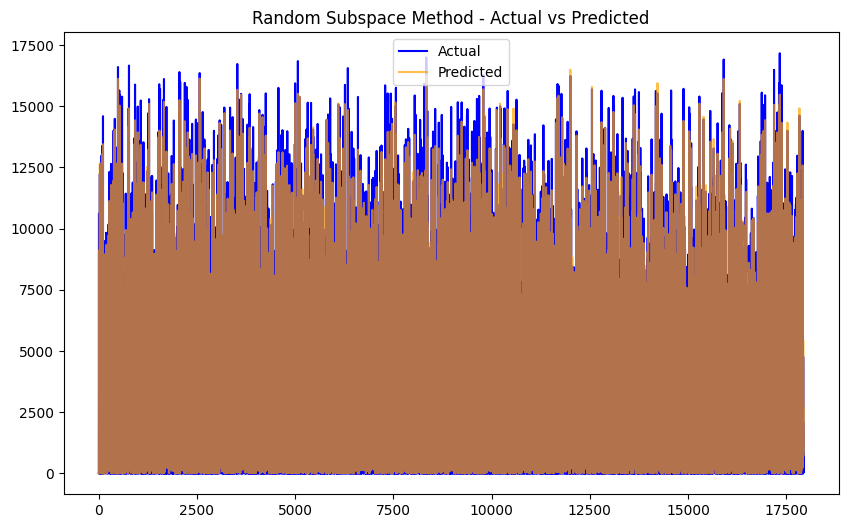

In [15]:
# Line plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_rsm, label='Predicted', alpha=0.7, color='orange')
plt.title('Random Subspace Method - Actual vs Predicted')
plt.legend()
plt.show()


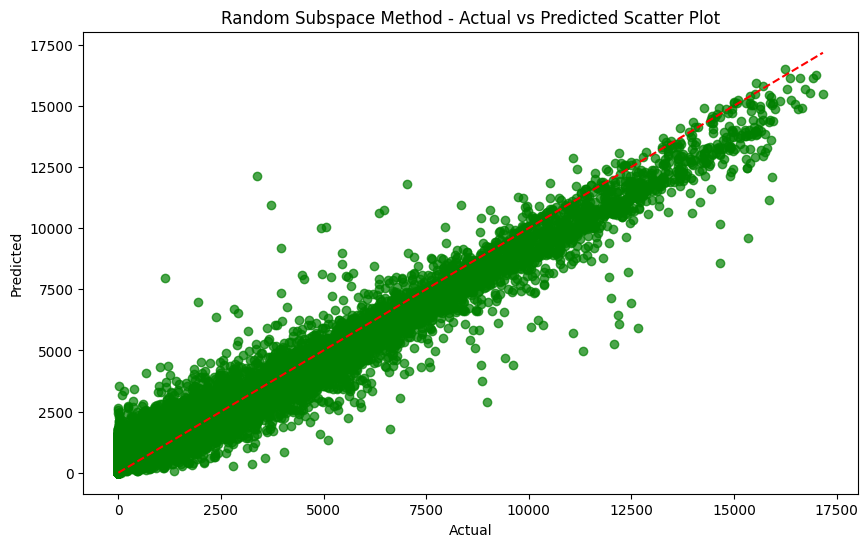

In [16]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test.values, y_pred_rsm, alpha=0.7, color='green')
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Subspace Method - Actual vs Predicted Scatter Plot')
plt.show()

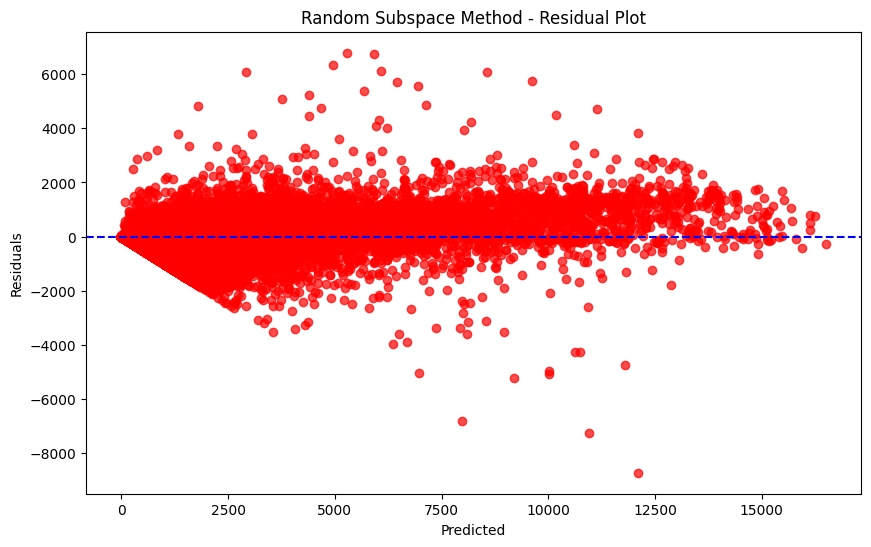

In [17]:
# Residual plot
residuals = y_test.values - y_pred_rsm
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rsm, residuals, alpha=0.7, color='red')
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Random Subspace Method - Residual Plot')
plt.show()


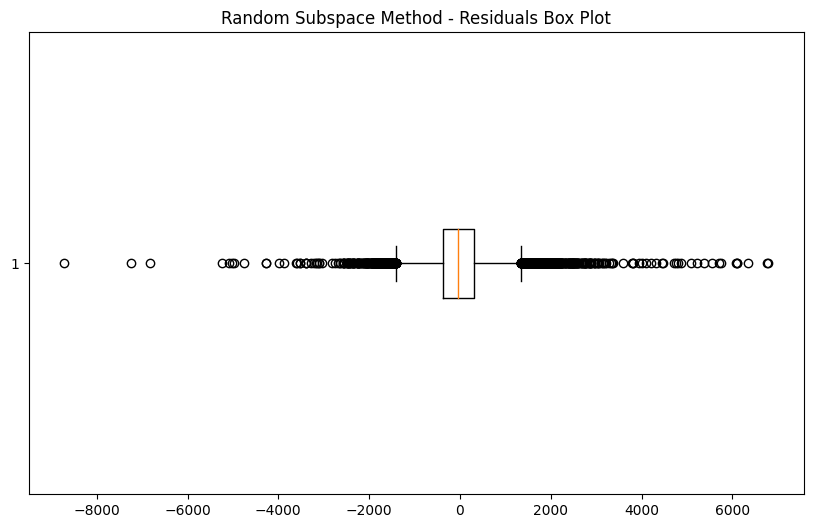

In [19]:
# Box plot of residuals
plt.figure(figsize=(10, 6))
plt.boxplot(residuals, vert=False)
plt.title('Random Subspace Method - Residuals Box Plot')
plt.show()
